In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [29]:
img=cv2.imread("image0.png",cv2.IMREAD_GRAYSCALE) #reading the image as an numpy array in gray scale mode
h,w=img.shape                                    # getting its height ad width

In [30]:
# defining my own convolution function 

def convolution(image,w,h,kernel,kernel_size):
     kernel=np.transpose(kernel)                                      #flipping the kernel
     convoluted_image=np.ones((h,w))
     # Applying convolution                                  
     for row in range(kernel_size//2,h-kernel_size//2):
          for col in range(kernel_size//2,w-kernel_size//2):
               
               convoluted_image[row,col]=np.sum(np.multiply(image[row-kernel_size//2:row+kernel_size//2+1,col-kernel_size//2:col+kernel_size//2+1],kernel))
               
               # Taking care of th cases in which pixel values are out of bound
               
               if convoluted_image[row,col] < 0:
                    convoluted_image[row,col] = -convoluted_image[row,col] # Since in edge detection, we are calculating intensity gradient, so it would be better to make the negatives positive rather than making them zero
               elif convoluted_image[row,col] > 255:
                    convoluted_image[row,col] = 255

               

     return convoluted_image

In [31]:
# threshholding after edge is detected so that every edge has the same intensity
def thresholding(image,w,h):
     high = 255*0.3                #settled on the value after experimentation
     low = high*0.05

     final_img = np.zeros((h,w))
     
     weak =0
     strong = 255
     
     strong_i, strong_j = np.where(image >= high)
     
     weak_i, weak_j = np.where((image<= high) & (image >= low))
     
     final_img[strong_i, strong_j] = strong
     final_img[weak_i,weak_j]=weak
     return final_img


In [32]:
#defining all the useful kernels that i will be using

sobel_x=[[-1,0,1],
         [-2,0,2],
         [-1,0,1]]
s_x=np.array(sobel_x)

sobel_y=[[-1,-2,-1],
         [0,0,0],
         [1,2,1]]
s_y=np.array(sobel_y)
sharpen=[[0,-1,0],
         [-1,4.09,-1],
         [0,-1,0]]
blur=[[1,1,1],
      [1,1,1],
      [1,1,1]]
gaussian_blur=[[1, 2, 1], 
    [2, 4, 2], 
    [1, 2, 1]]
g=np.array(gaussian_blur)/16

b=np.array(blur)/9
s=np.array(sharpen)

In [33]:
b_img=convolution(img,w,h,g/2,3).astype(np.uint8)  # here i have used g/2 or gaussian kernel/2 because it was performing better

In [34]:
sobel_img_x=convolution(b_img,w,h,s_x,3).astype(np.uint8)           #gradient in x dirn
sobel_img_y=convolution(b_img,w,h,s_y,3).astype(np.uint8)           #gradient in y dirn
final_img_sobel=np.hypot(sobel_img_x,sobel_img_y)                   #net gradient 

In [35]:
%matplotlib inline              
# allows us to display matplotlib charts in the notebook's interface only

# Sobel after Blur

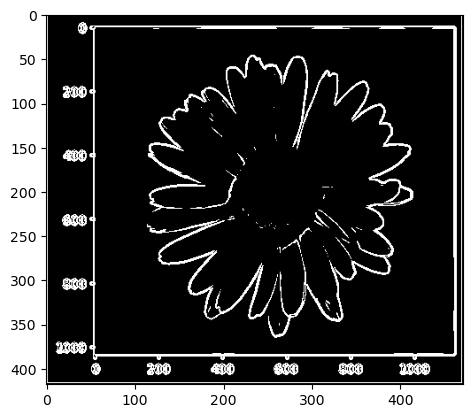

In [36]:
plt.imshow(thresholding(final_img_sobel,w,h),cmap='grey')

# Scharr after  blur

In [37]:
scharr_x=[[-3,0,3],
         [-10,0,10],
         [-3,0,3]]
sc_x=np.array(scharr_x)

scharr_y=[[-3,-10,-3],
         [0,0,0],
         [3,10,3]]
sc_y=np.array(scharr_y)

In [38]:
b_img=convolution(img,w,h,g/6,3).astype(np.uint8)  # again chose g/6 after experimentation

In [39]:
scharr_img_x=convolution(b_img,w,h,sc_x,3).astype(np.uint8)
scharr_img_y=convolution(b_img,w,h,sc_y,3).astype(np.uint8)
final_img_scharr=np.hypot(scharr_img_x,scharr_img_y)

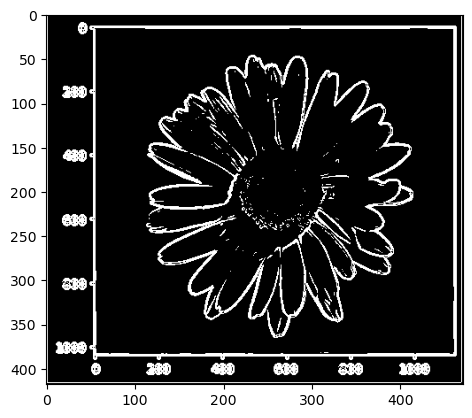

In [40]:
plt.imshow(thresholding(final_img_scharr,w,h),cmap='grey')

# applying canny edge detection

In [41]:


def Grad_approximate(n, base=45):  # this approximates my gradient direction to be the multipe of 45 degrees only 
    h,w=n.shape
    for row in range(h):
         for col in range(w):
              n[row,col]=base*round(n[row,col]/base)
    return n



def canny(image,w,h):
     sobel_x=[[-1,0,1],
          [-2,0,2],
          [-1,0,1]]
     s_x=np.array(sobel_x)

     sobel_y=[[-1,-2,-1],
          [0,0,0],
          [1,2,1]]
     s_y=np.array(sobel_y)

     gaussian_blur=[[1/16, 1/8, 1/16], 
     [1/8, 1/4, 1/8], 
     [1/16, 1/8, 1/16]]
     g=np.array(gaussian_blur)

     image=convolution(image,w,h,g,3).astype(np.uint8)
     Gx=convolution(image,w,h,s_x,3).astype(np.uint8)
     Gy=convolution(image,w,h,s_y,3).astype(np.uint8)
     G=np.hypot(Gx,Gy)                                                     # Magnitude of gradient of intensities
     theta = np.arctan2(Gy, Gx)*180/np.pi                                  # Dirn of gradient
     theta=Grad_approximate(theta)
     N_img=np.ones((h,w))

     # Non maximum suppresion - basically checking id the pixel in gradient dirn is a local maximum or not, 
     # if not, then removing it as it will not contribute to edge

     for row in range(h-1):
          for col in range(w-1):
               q=255
               r=255
               if theta[row,col]==0 or theta[row,col]==180 or theta[row,col]==-180:
                    q=G[row,col+1]
                    r=G[row,col-1]
               elif theta[row,col] ==90 or theta[row,col]==-90:
                    q=G[row+1,col]
                    r=G[row-1,col]
               elif theta[row,col]==45 or theta[row,col]==-135:
                    q=G[row-1,col+1]
                    r=G[row+1,col-1]
               elif theta[row,col]==-45 or theta[row,col]==135:
                    q=G[row-1,col-1]
                    r=G[row+1,col+1]
               if G[row,col]>= q and G[row,col]>=r:
                    N_img[row,col]=G[row,col]
               else:
                    N_img[row,col]=0
     
     #thresholding - makes the intensity of whole edge same
     
     high = 255*0.09
     low = high*0.05

     final_img = np.zeros((h,w))
     
     weak =30
     strong = 255
     
     strong_i, strong_j = np.where(N_img >= high)
     
     weak_i, weak_j = np.where((N_img <= high) & (N_img >= low))
     
     final_img[strong_i, strong_j] = strong
     final_img[weak_i,weak_j] = weak
     
     # hysteris - if a pixel is in between high and low parameter then we check if any of its surrounding pixels are strong, if yes then it is also converted to strong

     for i in range(1,h-1):
          for j in range(1,w-1):
               if final_img[i,j]==weak:
                    if ((final_img[i+1, j-1] == strong) or (final_img[i+1, j] == strong) or (final_img[i+1, j+1] == strong) or (final_img[i, j-1] == strong) or (final_img[i, j+1] == strong) or (final_img[i-1, j-1] == strong) or (final_img[i-1, j] == strong) or (final_img[i-1, j+1] == strong)):
                         final_img[i, j] = strong


               
     
     return final_img




               

     

In [42]:
canny_img=canny(img,w,h)

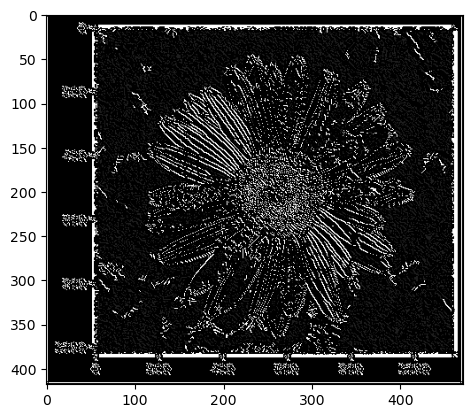

In [43]:
plt.imshow(canny_img,cmap='gray')     # its working so shitty :(